<a href="https://colab.research.google.com/github/Engr-M-Tahir/CGAN-Mnist/blob/main/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import lightning as L
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

In [ ]:
# Hyperparameters
latent_dim = 100
num_classes = 10
batch_size = 64
lr = 0.0002
epochs = 50

In [ ]:
# MNIST dataset with labels
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_loader = DataLoader(
    datasets.MNIST('.', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.92MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Embed labels and concatenate with noise vector
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z, labels):
        c = self.label_emb(labels)
        x = torch.cat([z, c], dim=1)
        return self.fc(x).view(-1, 1, 28, 28)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Embed labels and concatenate with flattened image
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.fc = nn.Sequential(
            nn.Linear(28*28 + num_classes, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        c = self.label_emb(labels)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat([x, c], dim=1)
        return self.fc(x)


In [ ]:
class GAN(L.LightningModule):
    def __init__(self):
        super(GAN, self).__init__()
        self.generator = Generator()
        self.discriminator = Discriminator()
        self.criterion = nn.BCELoss()
        self.automatic_optimization = False

    def forward(self, z, labels):
        return self.generator(z, labels)

    def configure_optimizers(self):
        optimizer_g = optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        optimizer_d = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
        return [optimizer_g, optimizer_d]

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        imgs = imgs.view(imgs.size(0), -1)

        real_labels = torch.full((imgs.size(0),), 1, dtype=torch.float, device=self.device)
        fake_labels = torch.full((imgs.size(0),), 0, dtype=torch.float, device=self.device)

        opt_g, opt_d = self.optimizers()

        # --- Train Discriminator ---
        outputs_real = self.discriminator(imgs, labels)
        d_loss_real = self.criterion(outputs_real.squeeze(), real_labels)

        z = torch.randn(imgs.size(0), latent_dim, device=self.device)
        sampled_labels = torch.randint(0, num_classes, (imgs.size(0),), device=self.device)
        fake_imgs = self.generator(z, sampled_labels)
        outputs_fake = self.discriminator(fake_imgs.detach(), sampled_labels)
        d_loss_fake = self.criterion(outputs_fake.squeeze(), fake_labels)

        d_loss = d_loss_real + d_loss_fake
        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()

        # --- Train Generator ---
        z = torch.randn(imgs.size(0), latent_dim, device=self.device)
        sampled_labels = torch.randint(0, num_classes, (imgs.size(0),), device=self.device)
        fake_imgs = self.generator(z, sampled_labels)
        outputs = self.discriminator(fake_imgs, sampled_labels)
        g_loss = self.criterion(outputs.squeeze(), real_labels)
        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()

        self.log('d_loss', d_loss, prog_bar=True, on_epoch=True)
        self.log('g_loss', g_loss, prog_bar=True, on_epoch=True)

        return g_loss

    def on_train_epoch_end(self):
        # Generate images for each class to visualize cGAN performance
        n_samples = 10
        z = torch.randn(n_samples, latent_dim, device=self.device)
        labels = torch.arange(0, n_samples, device=self.device)
        generated_images = self.generator(z, labels).view(n_samples, 28, 28).detach().cpu().numpy()

        plt.figure(figsize=(10, 2))
        for i in range(n_samples):
            plt.subplot(1, n_samples, i + 1)
            plt.imshow(generated_images[i], cmap='gray')
            plt.axis('off')
            plt.title(str(i))
        plt.show(block=True)


In [ ]:
# Set up TensorBoard logger
tensorboard_logger = TensorBoardLogger("lightning_logs", name="cGAN")


In [ ]:
# Set up model checkpointing
checkpoint_callback = ModelCheckpoint(
    monitor="g_loss",
    dirpath="checkpoints",
    filename="cgan-best-model",
    save_top_k=1,
    mode="min",
    verbose=True
)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 1.5 M  | train
1 | discriminator | Discriminator | 1.5 M  | train
2 | criterion     | BCELoss       | 0      | train
--------------------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.838    Total estimated model params size (MB)
23        Modules in train mode
0  

Training: |          | 0/? [00:00<?, ?it/s]

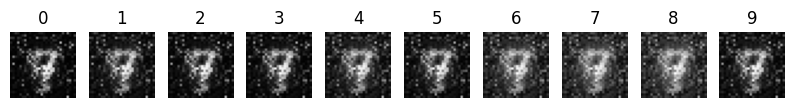

INFO: Epoch 0, global step 1876: 'g_loss' reached 3.01200 (best 3.01200), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 1876: 'g_loss' reached 3.01200 (best 3.01200), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


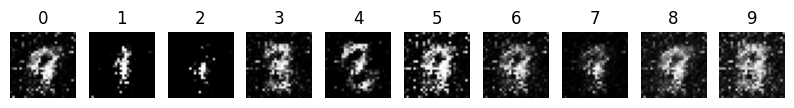

INFO: Epoch 1, global step 3752: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 3752: 'g_loss' was not in top 1


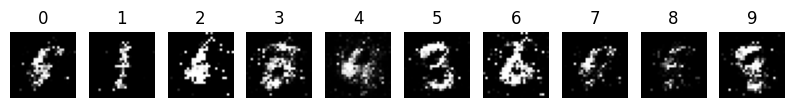

INFO: Epoch 2, global step 5628: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 5628: 'g_loss' was not in top 1


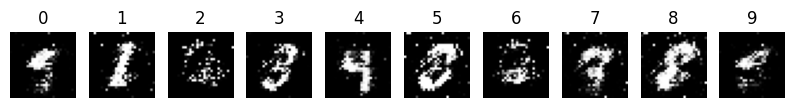

INFO: Epoch 3, global step 7504: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 7504: 'g_loss' was not in top 1


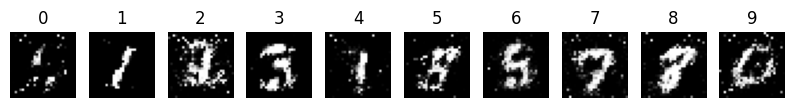

INFO: Epoch 4, global step 9380: 'g_loss' reached 2.49474 (best 2.49474), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 9380: 'g_loss' reached 2.49474 (best 2.49474), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


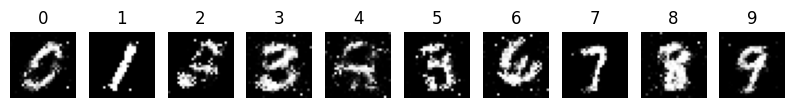

INFO: Epoch 5, global step 11256: 'g_loss' reached 2.09355 (best 2.09355), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 11256: 'g_loss' reached 2.09355 (best 2.09355), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


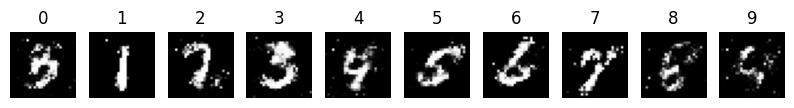

INFO: Epoch 6, global step 13132: 'g_loss' reached 1.70910 (best 1.70910), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 13132: 'g_loss' reached 1.70910 (best 1.70910), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


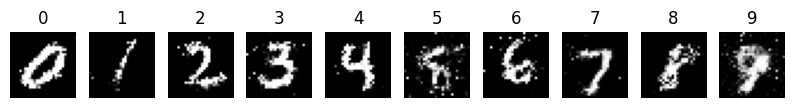

INFO: Epoch 7, global step 15008: 'g_loss' reached 1.60248 (best 1.60248), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 15008: 'g_loss' reached 1.60248 (best 1.60248), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


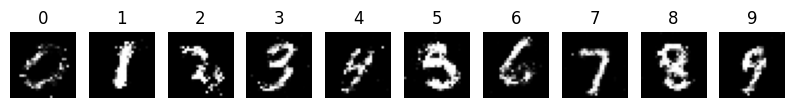

INFO: Epoch 8, global step 16884: 'g_loss' reached 1.42927 (best 1.42927), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 16884: 'g_loss' reached 1.42927 (best 1.42927), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


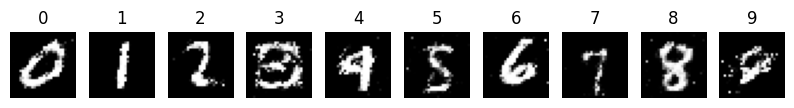

INFO: Epoch 9, global step 18760: 'g_loss' reached 1.35386 (best 1.35386), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 18760: 'g_loss' reached 1.35386 (best 1.35386), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


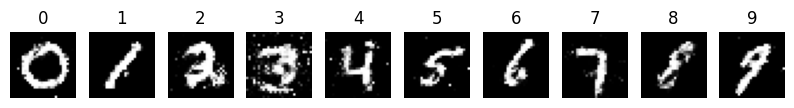

INFO: Epoch 10, global step 20636: 'g_loss' reached 1.27918 (best 1.27918), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 20636: 'g_loss' reached 1.27918 (best 1.27918), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


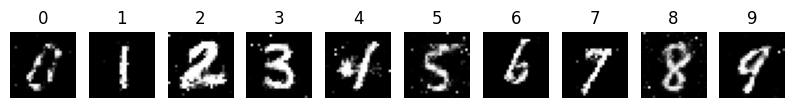

INFO: Epoch 11, global step 22512: 'g_loss' reached 1.21921 (best 1.21921), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 22512: 'g_loss' reached 1.21921 (best 1.21921), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


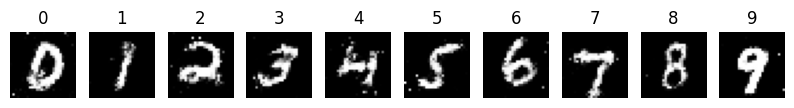

INFO: Epoch 12, global step 24388: 'g_loss' reached 1.17661 (best 1.17661), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 24388: 'g_loss' reached 1.17661 (best 1.17661), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


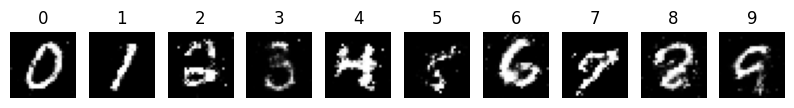

INFO: Epoch 13, global step 26264: 'g_loss' reached 1.16206 (best 1.16206), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 26264: 'g_loss' reached 1.16206 (best 1.16206), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


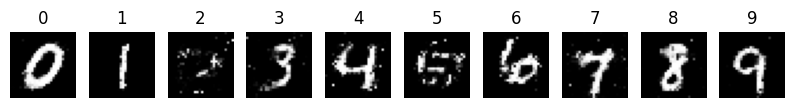

INFO: Epoch 14, global step 28140: 'g_loss' reached 1.15785 (best 1.15785), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 28140: 'g_loss' reached 1.15785 (best 1.15785), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


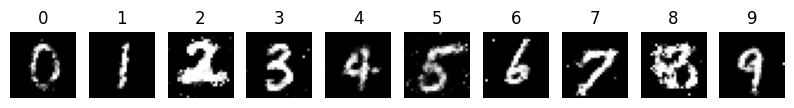

INFO: Epoch 15, global step 30016: 'g_loss' reached 1.13254 (best 1.13254), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 30016: 'g_loss' reached 1.13254 (best 1.13254), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


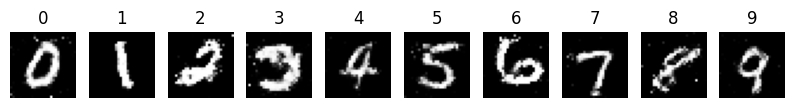

INFO: Epoch 16, global step 31892: 'g_loss' reached 1.11352 (best 1.11352), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 31892: 'g_loss' reached 1.11352 (best 1.11352), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


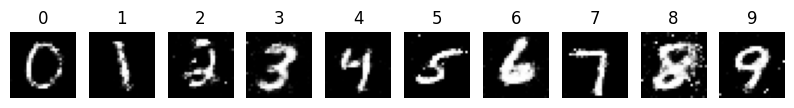

INFO: Epoch 17, global step 33768: 'g_loss' reached 1.10075 (best 1.10075), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 33768: 'g_loss' reached 1.10075 (best 1.10075), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


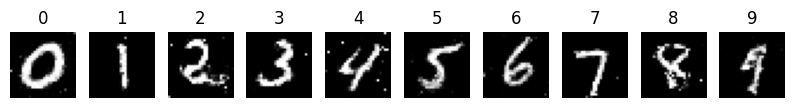

INFO: Epoch 18, global step 35644: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 35644: 'g_loss' was not in top 1


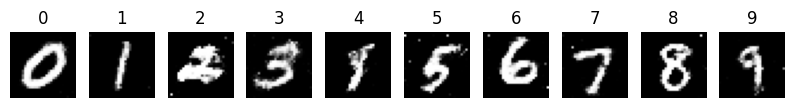

INFO: Epoch 19, global step 37520: 'g_loss' reached 1.08459 (best 1.08459), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 37520: 'g_loss' reached 1.08459 (best 1.08459), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


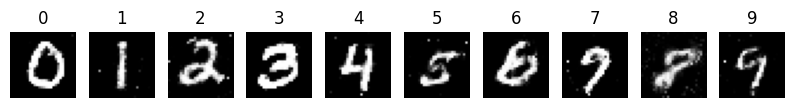

INFO: Epoch 20, global step 39396: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 20, global step 39396: 'g_loss' was not in top 1


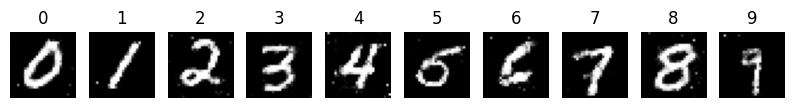

INFO: Epoch 21, global step 41272: 'g_loss' reached 1.08256 (best 1.08256), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 21, global step 41272: 'g_loss' reached 1.08256 (best 1.08256), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


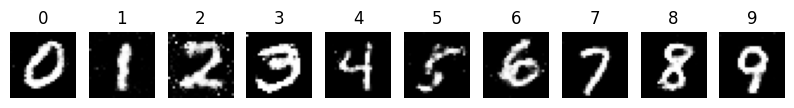

INFO: Epoch 22, global step 43148: 'g_loss' reached 1.07990 (best 1.07990), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 22, global step 43148: 'g_loss' reached 1.07990 (best 1.07990), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


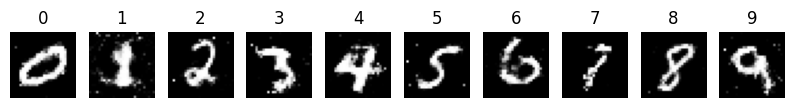

INFO: Epoch 23, global step 45024: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 23, global step 45024: 'g_loss' was not in top 1


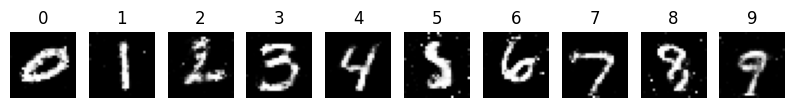

INFO: Epoch 24, global step 46900: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 24, global step 46900: 'g_loss' was not in top 1


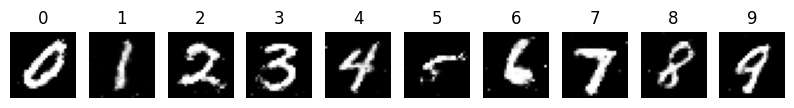

INFO: Epoch 25, global step 48776: 'g_loss' reached 1.07023 (best 1.07023), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 25, global step 48776: 'g_loss' reached 1.07023 (best 1.07023), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


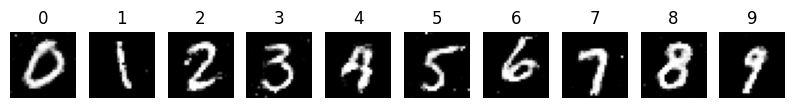

INFO: Epoch 26, global step 50652: 'g_loss' reached 1.06790 (best 1.06790), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 26, global step 50652: 'g_loss' reached 1.06790 (best 1.06790), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


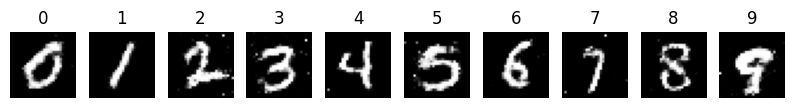

INFO: Epoch 27, global step 52528: 'g_loss' reached 1.06668 (best 1.06668), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 27, global step 52528: 'g_loss' reached 1.06668 (best 1.06668), saving model to '/content/checkpoints/cgan-best-model.ckpt' as top 1


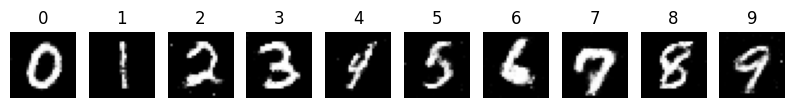

INFO: Epoch 28, global step 54404: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 28, global step 54404: 'g_loss' was not in top 1


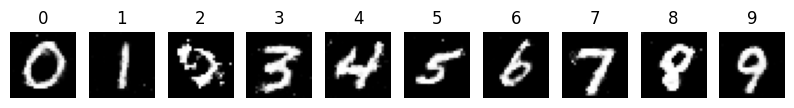

INFO: Epoch 29, global step 56280: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 29, global step 56280: 'g_loss' was not in top 1


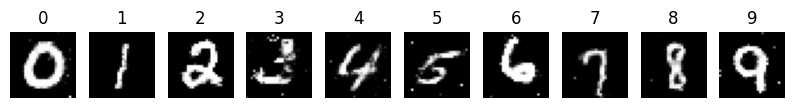

INFO: Epoch 30, global step 58156: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 30, global step 58156: 'g_loss' was not in top 1


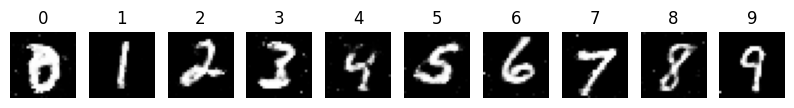

INFO: Epoch 31, global step 60032: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 31, global step 60032: 'g_loss' was not in top 1


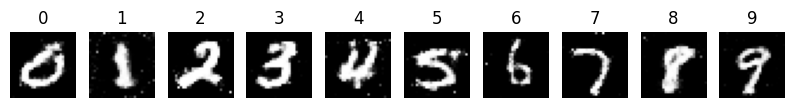

INFO: Epoch 32, global step 61908: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 32, global step 61908: 'g_loss' was not in top 1


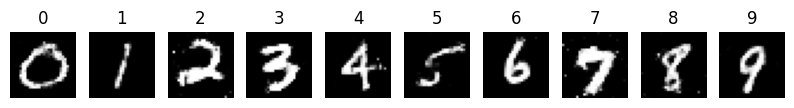

INFO: Epoch 33, global step 63784: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 33, global step 63784: 'g_loss' was not in top 1


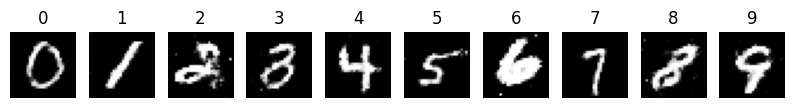

INFO: Epoch 34, global step 65660: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 34, global step 65660: 'g_loss' was not in top 1


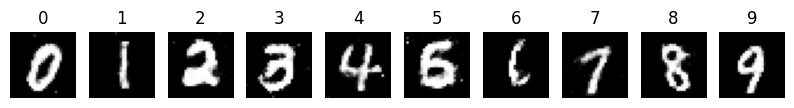

INFO: Epoch 35, global step 67536: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 35, global step 67536: 'g_loss' was not in top 1


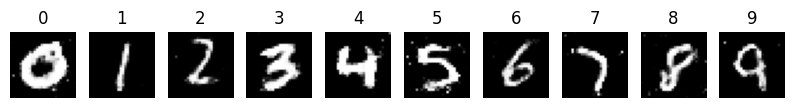

INFO: Epoch 36, global step 69412: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 36, global step 69412: 'g_loss' was not in top 1


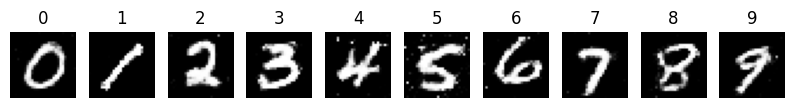

INFO: Epoch 37, global step 71288: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 37, global step 71288: 'g_loss' was not in top 1


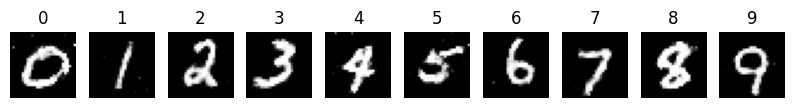

INFO: Epoch 38, global step 73164: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 38, global step 73164: 'g_loss' was not in top 1


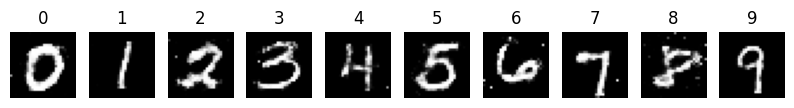

INFO: Epoch 39, global step 75040: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 39, global step 75040: 'g_loss' was not in top 1


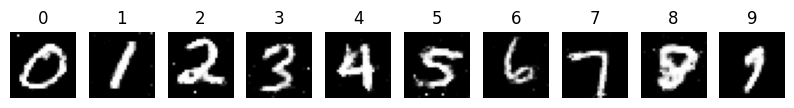

INFO: Epoch 40, global step 76916: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 40, global step 76916: 'g_loss' was not in top 1


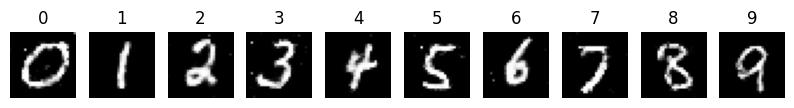

INFO: Epoch 41, global step 78792: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 41, global step 78792: 'g_loss' was not in top 1


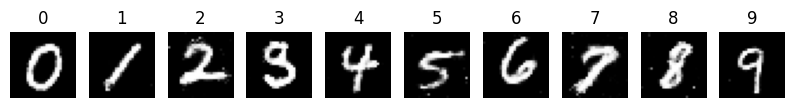

INFO: Epoch 42, global step 80668: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 42, global step 80668: 'g_loss' was not in top 1


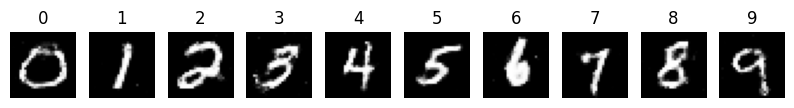

INFO: Epoch 43, global step 82544: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 43, global step 82544: 'g_loss' was not in top 1


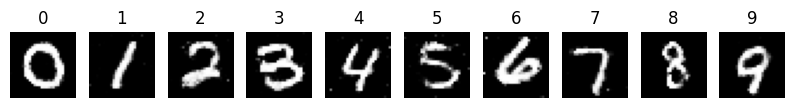

INFO: Epoch 44, global step 84420: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 44, global step 84420: 'g_loss' was not in top 1


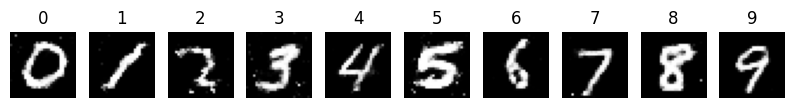

INFO: Epoch 45, global step 86296: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 45, global step 86296: 'g_loss' was not in top 1


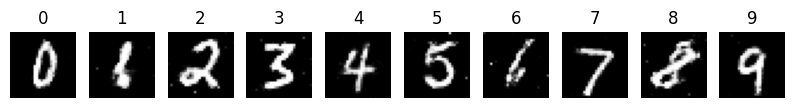

INFO: Epoch 46, global step 88172: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 46, global step 88172: 'g_loss' was not in top 1


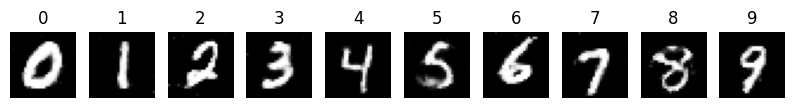

INFO: Epoch 47, global step 90048: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 47, global step 90048: 'g_loss' was not in top 1


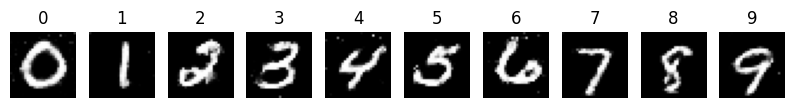

INFO: Epoch 48, global step 91924: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 48, global step 91924: 'g_loss' was not in top 1


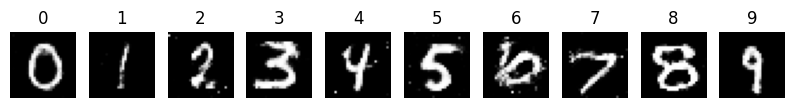

INFO: Epoch 49, global step 93800: 'g_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 49, global step 93800: 'g_loss' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
# Train the Conditional GAN
model = GAN()
trainer = L.Trainer(
    max_epochs=epochs,
    accelerator="gpu",
    logger=tensorboard_logger,
    callbacks=[checkpoint_callback],
    log_every_n_steps=1
)
trainer.fit(model, train_loader)

Please input your class id:4


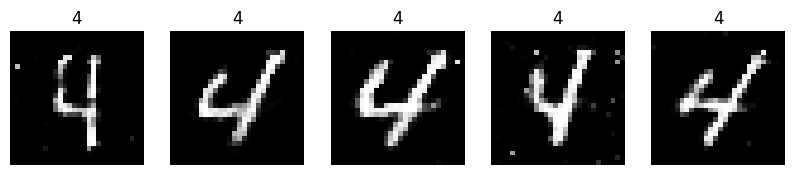

In [ ]:
model.eval()
device = next(model.parameters()).device

num_samples = 5  # how many images you want to generate
class_id = int(input('Please input your class id:'))    # the digit you want to generate

z = torch.randn(num_samples, latent_dim, device=device)
labels = torch.full((num_samples,), class_id, dtype=torch.long, device=device)

with torch.no_grad():
    generated_imgs = model.generator(z, labels).cpu()

# Plot or save generated_imgs as needed
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(generated_imgs[i].view(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(str(class_id))
plt.show()
